In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils import plotting_neuronal_behavioural, prep_data, preprocess_data, plot_latent_timeseries, plot_phase_space
from src.data_loading import DatabaseStimuli
from src.bundlenet import BunDLeNet, train_model
import tensorflow as tf
import os
os.chdir('../..')
os.getcwd()

'/Users/aksheykumar/Desktop/BunDLe-Net'

## Load Data (excluding behavioural neurons)

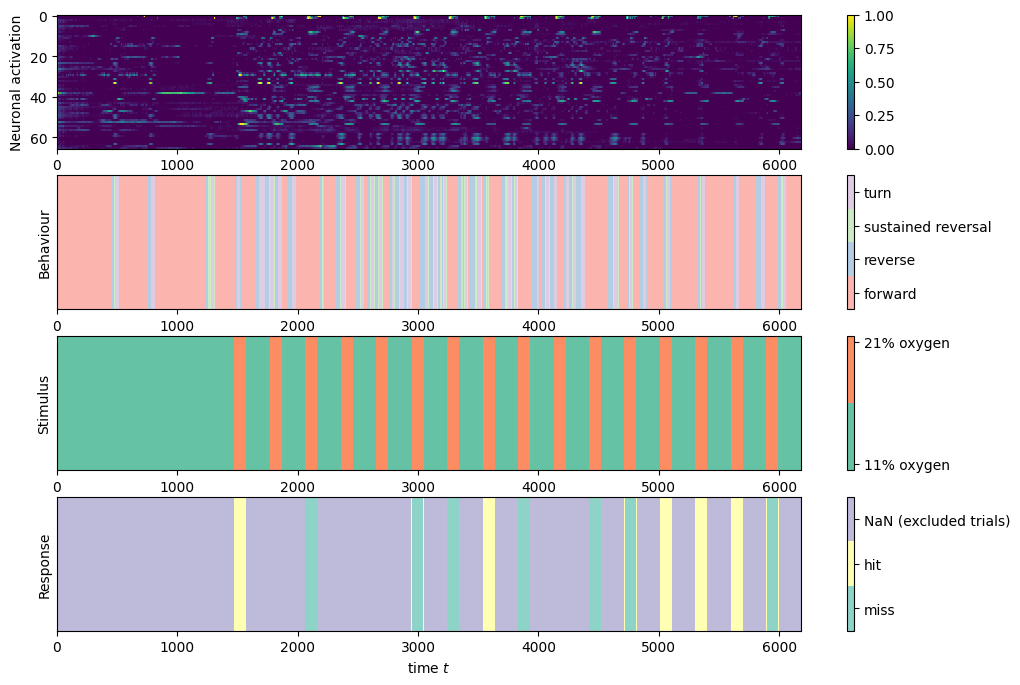

In [2]:
worm_num = 6
b_neurons = [
    'AVAR',
    'AVAL',
]
data = DatabaseStimuli(data_set_no=worm_num)
data.exclude_neurons(b_neurons)
X = data.neuron_traces.T
B = data.states
algorithm = 'BunDLeNet'

plotting_neuronal_behavioural(X, B, data.state_names, data.stimulus, data.stimulus_names, data.response, data.response_names, vmin=0, vmax=1)

## Preprocess data and embed with BunDLe-Net

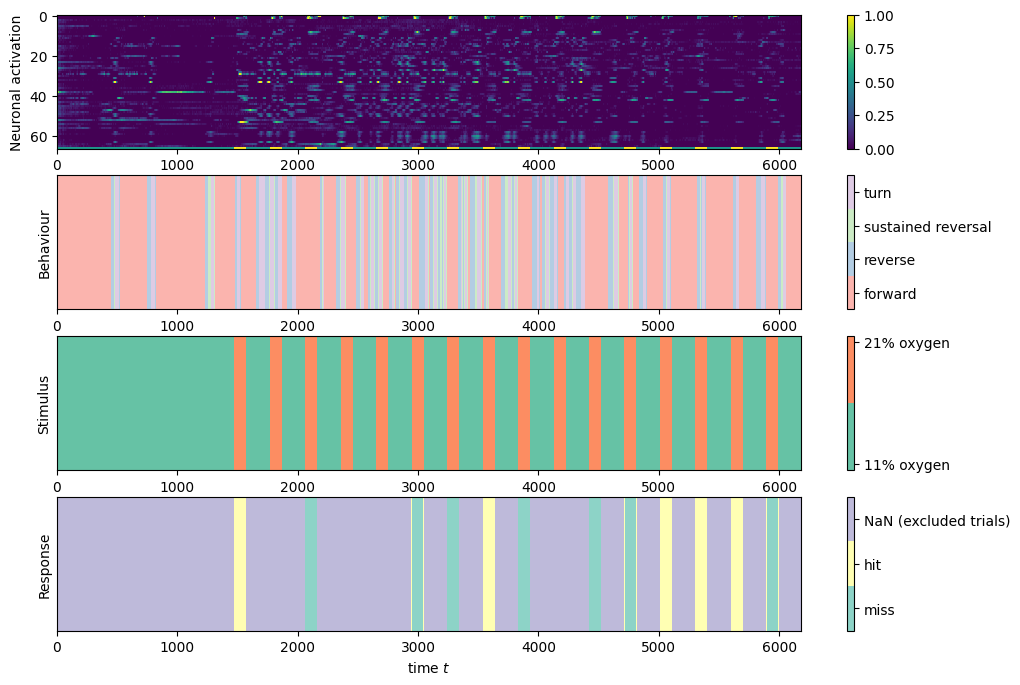

In [84]:

XnS = np.c_[X, data.stimulus/21.]
XnS.shape, X.shape

plotting_neuronal_behavioural(XnS, B, data.state_names, data.stimulus, data.stimulus_names, data.response, data.response_names, vmin=0, vmax=1)

In [85]:
### Preprocess and prepare data for BundLe Net
#time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(XnS, B, win=30)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

loss_array = train_model(
    X_,
    B_,
    model,
    optimizer,
    gamma=0.9, 
    n_epochs=500,
    pca_init=False,
    best_of_5_init=False
)

Losses 0.003866 0.000046 0.003912: 100%|████████████████████████████| 500/500 [01:21<00:00,  6.10it/s]


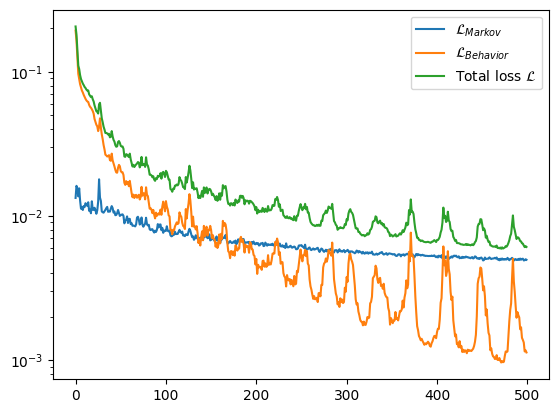

In [86]:
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
	plt.semilogy(loss_array[:,i], label=label)
plt.legend()
plt.show()

## Projecting into latent space

In [87]:
Y0_ = model.tau(X_[:,0]).numpy()

### Save the weights (Uncomment to save and load for for later use)
model.save_weights('data/generated/BunDLeNet_model_worm_' + str(worm_num))
np.savetxt('data/generated/saved_Y/Y0__' + algorithm + '_worm_' + str(worm_num), Y0_)
np.savetxt('data/generated/saved_Y/B__' + algorithm + '_worm_' + str(worm_num), B_)

In [88]:
Y0_ = np.loadtxt('data/generated/saved_Y/Y0__' + algorithm + '_worm_' + str(worm_num))
B_ = np.loadtxt('data/generated/saved_Y/B__' + algorithm + '_worm_' + str(worm_num)).astype(int)

## Visualising embedding

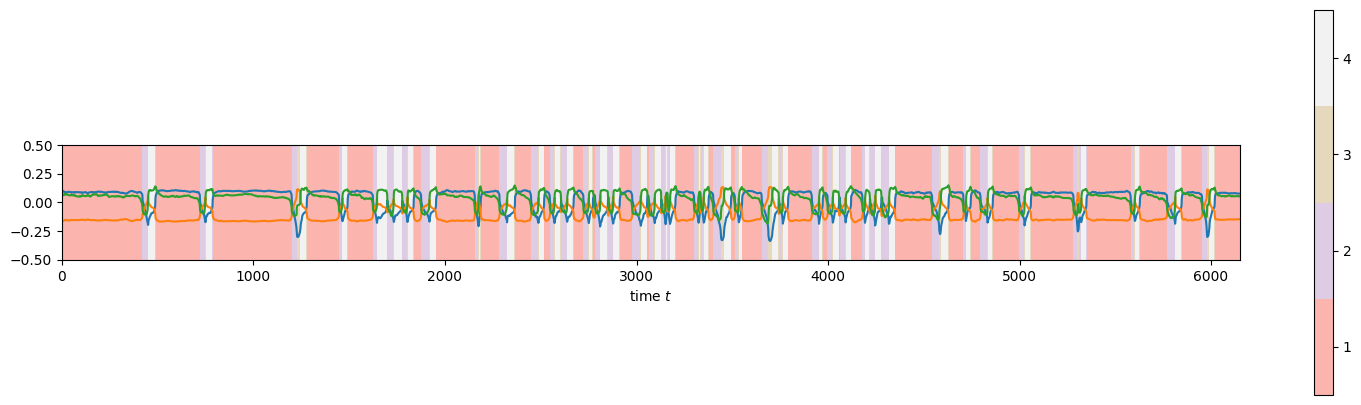

In [89]:
plot_latent_timeseries(Y0_, B_, data.state_names)

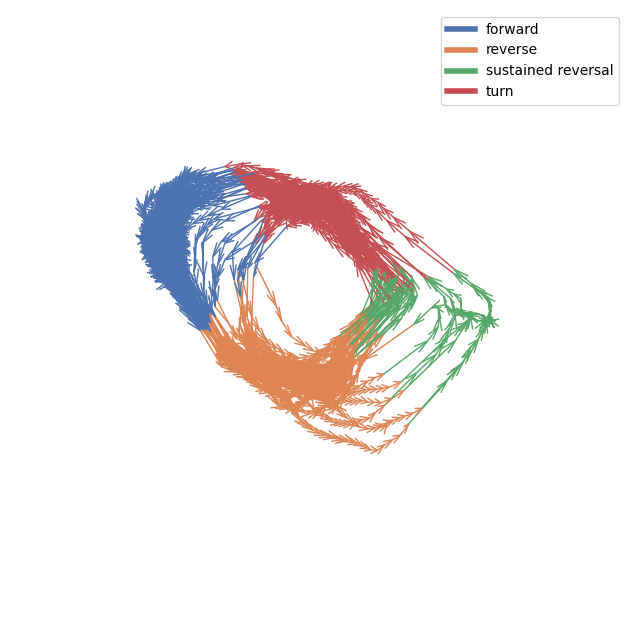

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [96]:
#plot_phase_space(Y0_[1500:2000], B_[1500:2000], state_names = data.state_names, legend=True, elev=0., azim=-0.)
plot_phase_space(Y0_, B_, state_names = data.state_names, legend=True, elev=0., azim=0.)

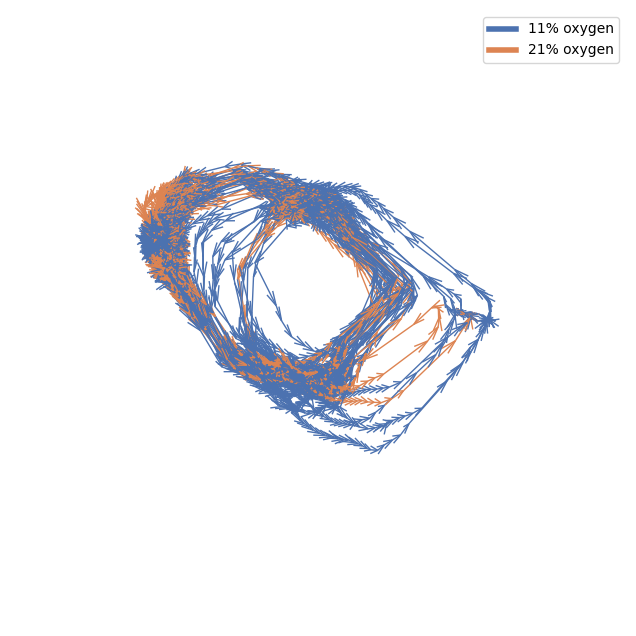

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [97]:
plot_phase_space(Y0_, data.stimulus, state_names = data.stimulus_names, legend=True, elev=0., azim=0.)

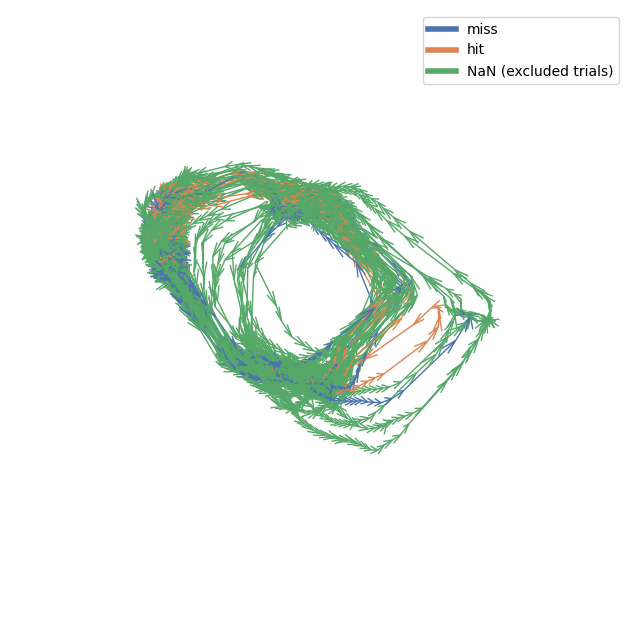

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [98]:
plot_phase_space(Y0_, data.response, state_names = data.response_names, legend=True, elev=0., azim=0.)

In [19]:
### Run to produce rotating 3-D plot
#%matplotlib notebook
# rotating_plot(Y0_, B_,filename='figures/rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif', state_names=state_names, legend=False)

### Performing PCA on the latent dimension (to check if there are redundant or correlated components)


In [ ]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_)
plot_latent_timeseries(Y_pca, B_, state_names)

### Recurrence plot analysis of BunDLeNet's embedding

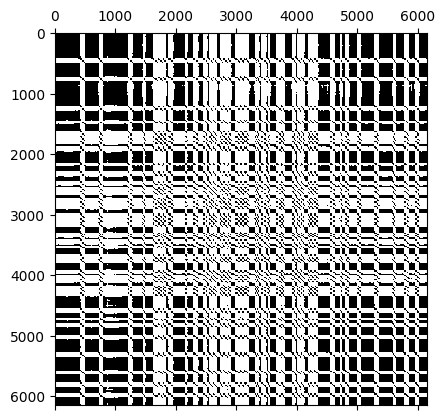

In [53]:
pd_Y = np.linalg.norm(Y0_[:, np.newaxis] - Y0_, axis=-1) < 0.8
plt.matshow(pd_Y, cmap='Greys')
plt.show()